In [1]:
import pennylane as qml
from pennylane import numpy as np

Circuit

In [2]:
dev = qml.device("default.qubit", wires=4)

In [3]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [4]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [5]:
@qml.qnode(dev, interface="autograd")
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

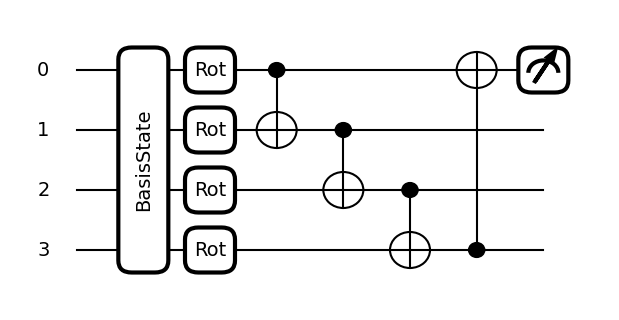

In [6]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(0.01 * np.random.randn(1, 4, 3, requires_grad=True), [1, 0, 1, 1])
fig.set_size_inches((6, 3))

In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Cost

In [8]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [9]:
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [10]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Optimization

In [11]:
data = np.loadtxt("../data/PennyLane/parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")
X.requires_grad = False
Y.requires_grad = False

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


In [12]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [13]:
opt = qml.NesterovMomentumOptimizer(0.5)
batch_size = 5

In [14]:
weights = weights_init
bias = bias_init
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, x, y = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print("Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(it + 1, cost(weights, bias, X, Y), acc))

Iter:     1 | Cost: 3.4355534 | Accuracy: 0.5000000 
Iter:     2 | Cost: 1.9287800 | Accuracy: 0.5000000 
Iter:     3 | Cost: 2.0341238 | Accuracy: 0.5000000 
Iter:     4 | Cost: 1.6372574 | Accuracy: 0.5000000 
Iter:     5 | Cost: 1.3025395 | Accuracy: 0.6250000 
Iter:     6 | Cost: 1.4555019 | Accuracy: 0.3750000 
Iter:     7 | Cost: 1.4492786 | Accuracy: 0.5000000 
Iter:     8 | Cost: 0.6510286 | Accuracy: 0.8750000 
Iter:     9 | Cost: 0.0566074 | Accuracy: 1.0000000 
Iter:    10 | Cost: 0.0053045 | Accuracy: 1.0000000 
Iter:    11 | Cost: 0.0809483 | Accuracy: 1.0000000 
Iter:    12 | Cost: 0.1115426 | Accuracy: 1.0000000 
Iter:    13 | Cost: 0.1460257 | Accuracy: 1.0000000 
Iter:    14 | Cost: 0.0877037 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.0361311 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.0040937 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.0004899 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.0005290 | Accuracy: 1.0000000 
Iter:    19 | Cost: 0.0024304 | Accuracy: 1.00